# Spaceship Titanic
Predict which passengers are transported to an alternate dimension

## Introduction
Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

<img src="https://storage.googleapis.com/kaggle-media/competitions/Spaceship%20Titanic/joel-filipe-QwoNAhbmLLo-unsplash.jpg" width=600>

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Help save them and change history!

## Libraries installing and dataset downloading

In [166]:
%%capture

! pip install kaggle
! pip install numpy
! pip install pandas
! pip install sklearn
! pip install matplotlib
! pip install seaborn

In [2]:
# Flag to force to reload dataset
RELOAD = False

In [3]:
import os
from zipfile import ZipFile

# import Kaggle API to load dataset
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

# initialize Kaggle API
api = KaggleApi()
api.authenticate()

# download dataset from Kaggle to data folder
data_path = 'data'
api.competition_download_files('spaceship-titanic', data_path, force=RELOAD, quiet=False)

dataset_file_name = 'spaceship-titanic.zip'


with ZipFile(os.path.join(data_path, dataset_file_name), 'r') as zip_ref:
    zip_ref.extractall(data_path)

spaceship-titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


## Data description
* **train.csv** - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
    - `PassengerId` - A unique Id for each passenger. Each Id takes the form `gggg_pp` where `gggg` indicates a group the passenger is travelling with and `pp` is their number within the group. People in a group are often family members, but not always.
    - `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
    - `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
    - `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
    - `Destination` - The planet the passenger will be debarking to.
    - `Age` - The age of the passenger.
    - `VIP` - Whether the passenger has paid for special VIP service during the voyage.
    - `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    - `Name` - The first and last names of the passenger.
    - `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
* **test.csv** - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of `Transported` for the passengers in this set.
* **sample_submission.csv** - A submission file in the correct format.
    - `PassengerId` - Id for each passenger in the test set.
    - `Transported` - The target. For each passenger, predict either `True` or `False`.

In [4]:
import pandas as pd

# Load data to variables
df = pd.read_csv(os.path.join(data_path, 'train.csv'))                                          # This dataset will be split on train-test-val
df_kaggle_test = pd.read_csv(os.path.join(data_path, 'test.csv'))                               # This dataset doesn't have labels, so will not be used for any of analysis/modeling, only final prediction
df_kaggle_sample_submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))     # This is an example of submission 

In [5]:
# Check shapes of loaded df's
print(f'Shape of df: {str(df.shape)}')
print(f'Shape of df_kaggle_test: {str(df_kaggle_test.shape)}')
print(f'Shape of df_kaggle_sample_submission: {str(df_kaggle_sample_submission.shape)}')

Shape of df: (8693, 14)
Shape of df_kaggle_test: (4277, 13)
Shape of df_kaggle_sample_submission: (4277, 2)


## Exploratory Data Analysis

First, let's take a look on df, it's head and structure

In [6]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [7]:
df.columns.to_list()

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Name',
 'Transported']

### Univariate analysis

#### PassengerId

In [8]:
# All passengerIDs should be unique, but let's check
print(f'Unique passangerIDs: {len(df.PassengerId.unique())} out of {len(df)} total records')

Unique passangerIDs: 8693 out of 8693 total records


Many passengers travel in groups (see field descriptiuon), let's extract group number from passengerID

In [9]:
df[['GroupId', 'PassengerId_no_group']] = df['PassengerId'].str.split('_', expand=True)

In [10]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,PassengerId_no_group
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,02
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,01


In [11]:
# Check number of groups
print(f'Unique GroupIDs: {len(df.GroupId.unique())} out of {len(df)} total records')

Unique GroupIDs: 6217 out of 8693 total records


In [12]:
# Maximum and minimum amount of passangers in each group
df.groupby('GroupId')['PassengerId'].count().max(), df.groupby('GroupId')['PassengerId'].count().min()

(8, 1)

In [13]:
# Add group size as column
df = pd.merge(df, df.groupby('GroupId')['PassengerId'].count(), on='GroupId')
# Rename columns, that they are more meaningful
df.rename({'PassengerId_y': 'Group_size', 'PassengerId_x': 'Full_Id', 'PassengerId_no_group': 'PassengerId'}, axis=1, inplace=True)

In [14]:
df.head()

,Full_Id,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,PassengerId,Group_size
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,02,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,01,1


In [143]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    '''
    https://stackoverflow.com/a/18926541
    '''
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def plot_groups(column, df=df, xlabel='', ylablel='', title=''):
    grouped_df = df.groupby([column]).size()

    plt.figure(figsize=(10,5))

    data_norm = [(x) / max(grouped_df) for x in grouped_df]
    my_cmap = plt.cm.get_cmap('PuBu')
    my_cmap = truncate_colormap(my_cmap, 0.4, 0.8)
    #new_cmap = sub_cmap(my_cmap, 0.2, 0.9)
    colors = my_cmap(data_norm)

    # df.groupby(['Group_size']).size().plot(kind='bar', rot=0, colormap = 'flag')
    grouped_df.plot(kind='bar', rot=0, color=colors)
    plt.xlabel(xlabel)
    plt.ylabel(ylablel)
    plt.title(title)
    plt.show();


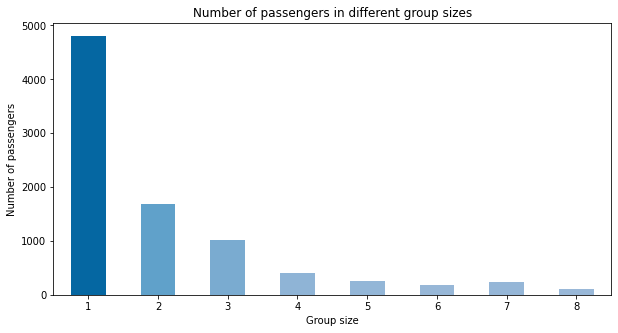

In [144]:
# Group size visualization
plot_groups('Group_size', xlabel='Group size', ylablel='Number of passengers', title='Number of passengers in different group sizes')

About half of the passengers in the test set traveled alone. Groups of 2 or 3 people are also common. 

#### HomePlanet

In [16]:
# HomePlanet field
df['HomePlanet'].unique()

array(['Europa', 'Earth', 'Mars', nan], dtype=object)

In [17]:
df['HomePlanet'].isna().sum()

201

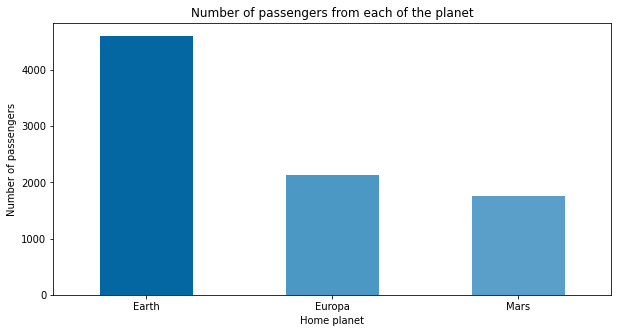

In [145]:
# How many passengers from each of the planet
plot_groups('HomePlanet', xlabel='Home planet', ylablel='Number of passengers', title='Number of passengers from each of the planet')

Only three home planets are in data. 201 records (out of 8693) are missing.

About half of the passengers are from Earth.

#### CryoSleep

In [41]:
df['CryoSleep'].unique()

array([False, True, nan], dtype=object)

In [19]:
df['CryoSleep'].isna().sum()

217

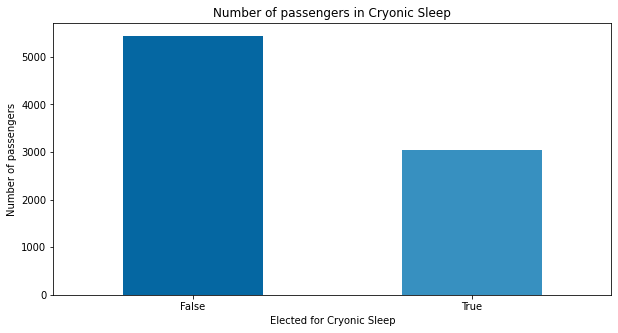

In [146]:
plot_groups('CryoSleep', xlabel='Elected for Cryonic Sleep', ylablel='Number of passengers', title='Number of passengers in Cryonic Sleep')

Options are False or True, 217 (out of 8693) values are missing

About 1/3 of the passengers from test set were elected for CryoSleep

#### Cabin

In [119]:
df['Cabin'].nunique()

6560

In [120]:
df['Cabin'].isna().sum()

199

Amount of unique cabin numbers is less than passengers number. So, not all passengers travelled in own cabin. Let's plot how many passengers were in the one cabin.

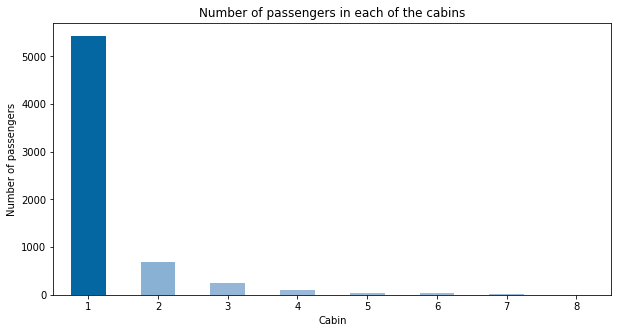

In [147]:
by_cabins_df = pd.DataFrame(df.groupby(by='Cabin').size())
plot_groups(0, df=by_cabins_df, xlabel='Cabin', ylablel='Number of passengers', title='Number of passengers in each of the cabins')

More than half of the passengers travelled alone in their cabins.

Cabin contains deck number, number of cabin on deck and side (P for Port or S for Starboard). Let's extract this information.

In [122]:
df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)

In [123]:
df.head()

,Full_Id,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,PassengerId,Group_size,Deck,Num,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01,1,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01,1,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01,2,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,02,2,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,01,1,F,1,S


In [124]:
df['Deck'].unique()

array(['B', 'F', 'A', 'G', nan, 'E', 'D', 'C', 'T'], dtype=object)

In [125]:
# Total number of unique cabin numbers
df['Num'].nunique()

1817

In [126]:
# Number of unique cabin numbers on each deck
df.groupby(by='Deck')['Num'].nunique()

Deck
A      97
B     312
C     301
D     251
E     527
F    1620
G    1341
T       4
Name: Num, dtype: int64

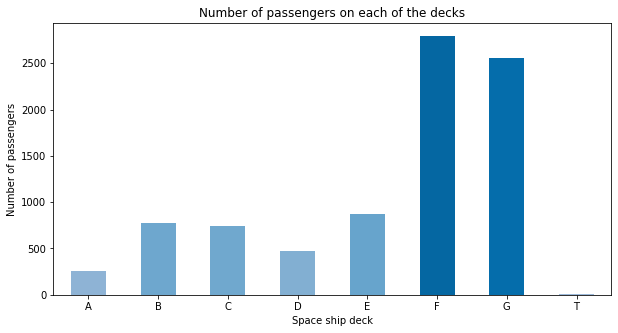

In [127]:
plot_groups('Deck', xlabel='Space ship deck', ylablel='Number of passengers', title='Number of passengers on each of the decks')

Most of the passengers had a cabin on decks `F` and `G`, which correlated with amount of cabins on each of the decks

In [43]:
df['Side'].unique()

array(['P', 'S', nan], dtype=object)

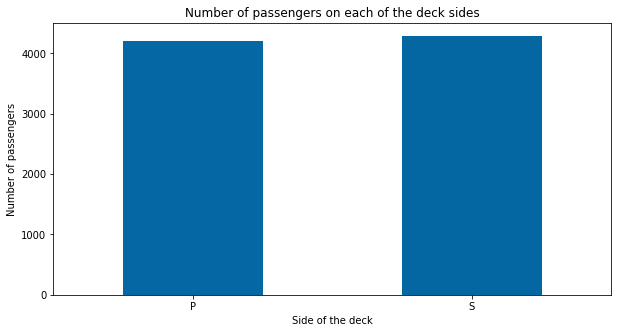

In [148]:
plot_groups('Side', xlabel='Side of the deck', ylablel='Number of passengers', title='Number of passengers on each of the deck sides')

Approximately the same amount of passengers cabins were located on each of spaceship sides.

199 records (out of 8693) are missing.

#### Destination

In [150]:
df['Destination'].nunique()

3

In [151]:
df['Destination'].isna().sum()

182

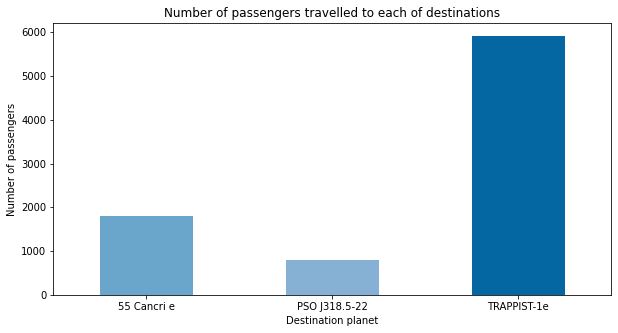

In [152]:
plot_groups('Destination', xlabel='Destination planet', ylablel='Number of passengers', title='Number of passengers travelled to each of destinations')

Vast majority of the passengers travelled to TRAPPIST-1e (https://en.wikipedia.org/wiki/TRAPPIST-1e), second popular destination is 55 Cancri e (https://en.wikipedia.org/wiki/55_Cancri_e), and finally, less than 1000 passenger travelled to PSO J318.5-22 (https://en.wikipedia.org/wiki/PSO_J318.5%E2%88%9222), which doesn't orbit a parent star.

182 (out of 8693) destination records are missing

#### Age

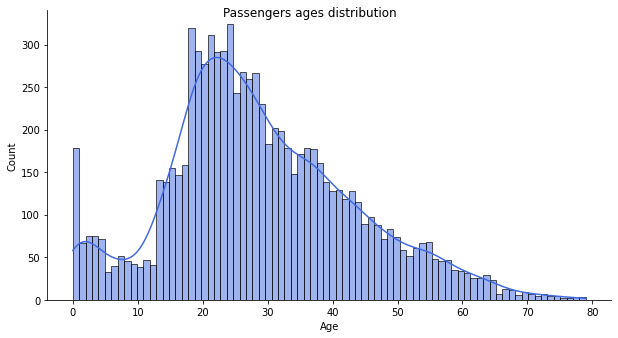

In [277]:
import seaborn as sns
g = sns.displot(df['Age'], kde=True, bins=80, color = 'royalblue', height=4.75, aspect=1.83)
g.fig.suptitle("Passengers ages distribution");

In [211]:
df['Age'].describe()

count    8514.000000
mean       28.827930
std        14.489021
min         0.000000
25%        19.000000
50%        27.000000
75%        38.000000
max        79.000000
Name: Age, dtype: float64

In [215]:
df['Age'].isna().sum()

179

Age distribution density plot looks like Positively skewed distribution with additional peak on the left. Half of the passengers are in between 19 and 38 years old, and also many children 0-5 years.

179 passengers (out of 8693) don't have age indicated

#### VIP

In [222]:
df['VIP'].unique()

array([False, True, nan], dtype=object)

In [223]:
df['VIP'].isna().sum()

203

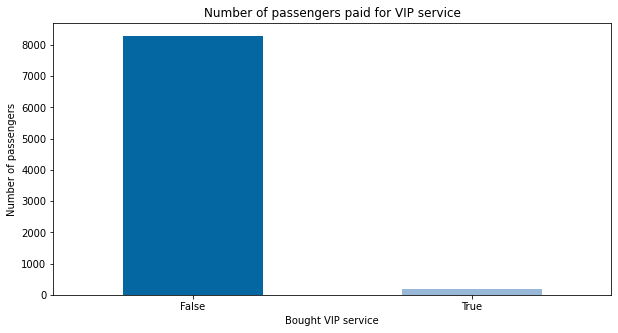

In [225]:
plot_groups('VIP', xlabel='Bought VIP service', ylablel='Number of passengers', title='Number of passengers paid for VIP service')

Only small part of the passengers had paid for VIP service. 203 records are missing

### Mony spent on additional services (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck)

In [268]:
df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].describe()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,224.687617,458.077203,173.729169,311.138778,304.854791
std,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,47.000000,76.000000,27.000000,59.000000,46.000000
max,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


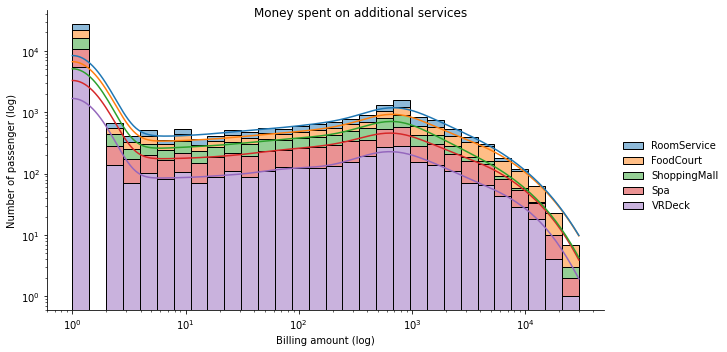

In [279]:
g = sns.displot(df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]+1, kde=True, bins=30, multiple="stack", height=4.75, aspect=1.83, log_scale=(True,True))
g.set_axis_labels("Billing amount (log)", "Number of passenger (log)")
g.fig.suptitle("Money spent on additional services");

In [282]:
df['RoomService'].isna().sum(), df['FoodCourt'].isna().sum(), df['ShoppingMall'].isna().sum(), df['Spa'].isna().sum(), df['VRDeck'].isna().sum()

(181, 183, 208, 183, 188)

Most of the passengers didn't spend money on all additional services, only 25% of passengers spent large amounts on each them.
About 180-200 records for each of these columns are missing.

#### Name

In [283]:
df['Name'].isna().sum()

200

In [284]:
df['Name'].nunique()

8473

In [290]:
len(df[(df.duplicated('Name')) & ~df['Name'].isna()])

20

200 passengers didn't indicate their names and 20 of them had full namesakes on the Spaceship

#### Transported

In [291]:
df['Transported'].isna().sum()

0

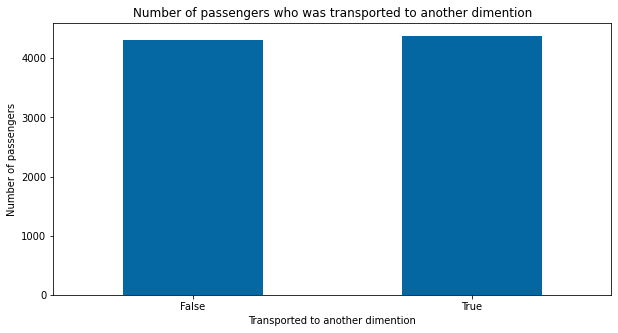

In [292]:
plot_groups('Transported', xlabel='Transported to another dimention', ylablel='Number of passengers', title='Number of passengers who was transported to another dimention')

About half of the passengers were sent to alternate dimension

### Multivariate analysis